- trend ratio between modelled GW trend from PCR-GLOBWB and observed TWS from GRACE

In [22]:
%reset -f
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import theilslopes
import scipy.ndimage
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

%matplotlib inline

In [23]:
TWS_trend_Grace = xr.open_dataset('/home/bauer013/ls/results_europe/masked_trends/TWS_trend_Grace_2002_2019.nc')
GW_trend_GLOBWB = xr.open_dataset('/home/bauer013/ls/results_europe/masked_trends/totGW_trend_GLOBWB_2002_2019_w5_15nonNaN_masked.nc')
ocean_mask = xr.open_dataset('/home/bauer013/ls/data/IMERG_land_sea_mask.nc')

In [24]:
# Reorder longitudes Grace
TWS_trend_Grace['lon'] = (TWS_trend_Grace['lon'] + 180) % 360 - 180
# Reorder longitudes
TWS_trend_Grace['lon'] = np.concatenate([TWS_trend_Grace['lon'].values[60:], TWS_trend_Grace['lon'].values[:60]])
# Update other variables in the dataset accordingly
slope_reordered = np.concatenate([TWS_trend_Grace['slope'].values[:, 60:], TWS_trend_Grace['slope'].values[:, :60]], axis=1)
intercept_reordered = np.concatenate([TWS_trend_Grace['intercept'].values[:, 60:], TWS_trend_Grace['intercept'].values[:, :60]], axis=1)
TS_var3_reordered = np.concatenate([TWS_trend_Grace['low_slope'].values[:, 60:], TWS_trend_Grace['low_slope'].values[:, :60]], axis=1)
TS_var4_reordered = np.concatenate([TWS_trend_Grace['high_slope'].values[:, 60:], TWS_trend_Grace['high_slope'].values[:, :60]], axis=1)
slope_da = xr.DataArray(slope_reordered, dims=('lat', 'lon'), coords={'lat': TWS_trend_Grace['lat'], 'lon': TWS_trend_Grace['lon']})
intercept_da = xr.DataArray(intercept_reordered, dims=('lat', 'lon'), coords={'lat': TWS_trend_Grace['lat'], 'lon': TWS_trend_Grace['lon']})
TS_var3_da = xr.DataArray(TS_var3_reordered, dims=('lat', 'lon'), coords={'lat': TWS_trend_Grace['lat'], 'lon': TWS_trend_Grace['lon']})
TS_var4_da = xr.DataArray(TS_var4_reordered, dims=('lat', 'lon'), coords={'lat': TWS_trend_Grace['lat'], 'lon': TWS_trend_Grace['lon']})
TWS_trend_Grace['slope'] = slope_da
TWS_trend_Grace['intercept'] = intercept_da
TWS_trend_Grace['low_slope'] = TS_var3_da
TWS_trend_Grace['high_slope'] = TS_var4_da

GW_trend_GLOBWB = GW_trend_GLOBWB.sortby('lat', ascending=True)


In [25]:
#ocean and temperture mask
#ocean mask fata from https://gpm.nasa.gov/data/directory/imerg-land-sea-mask-netcdf 23.04.2024
ocean_mask = ocean_mask.sel(lon=slice(0, 360))
ocean_mask = ocean_mask.sel(lon=(ocean_mask['lon'] < 60) | (ocean_mask['lon'] > 349))
ocean_mask = ocean_mask.sel(lat=(ocean_mask['lat'] > 35) & (ocean_mask['lat'] < 72 ))
ocean_mask = ocean_mask.coarsen(lon=10, lat=10).mean()
ocean_mask['lon'] = (ocean_mask['lon'] + 180) % 360 - 180
ocean_mask['lon'] = np.concatenate([ocean_mask['lon'].values[60:], ocean_mask['lon'].values[:60]])
slope_reordered = np.concatenate([ocean_mask['landseamask'].values[:, 60:], ocean_mask['landseamask'].values[:, :60]], axis=1)
ocean_mask['landseamask'] = xr.DataArray(slope_reordered, dims=('lat', 'lon'), coords={'lat': ocean_mask['lat'], 'lon': ocean_mask['lon']})

# adjust parameter. Which percentage needs to be water
ocean_mask = ocean_mask['landseamask'] > 75 # Typical percentage thresholds used to define sea are 100% (strictly open water) or 75% (including sea-ward coast areas)
ocean_mask['lat'] = np.round(ocean_mask['lat'], decimals=1)
ocean_mask['lon'] = np.round(ocean_mask['lon'], decimals=1)

TWS_trend_Grace['lat'] = np.round(TWS_trend_Grace['lat'], decimals=1)
TWS_trend_Grace['lon'] = np.round(TWS_trend_Grace['lon'], decimals=1)
TWS_trend_Grace = TWS_trend_Grace.where(~ocean_mask, np.nan)

In [26]:
#create dataset with trend ratio 
lon_range = GW_trend_GLOBWB['lon'].values 
lat_range = GW_trend_GLOBWB['lat'].values 

GW_TWS_trend_ratio = xr.Dataset(
    {'trend_ratio': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range))))},
    coords={'lat': lat_range, 'lon': lon_range},
)
GW_TWS_trend_ratio['trend_ratio'].values = GW_trend_GLOBWB['slope'].values/TWS_trend_Grace['slope'].values


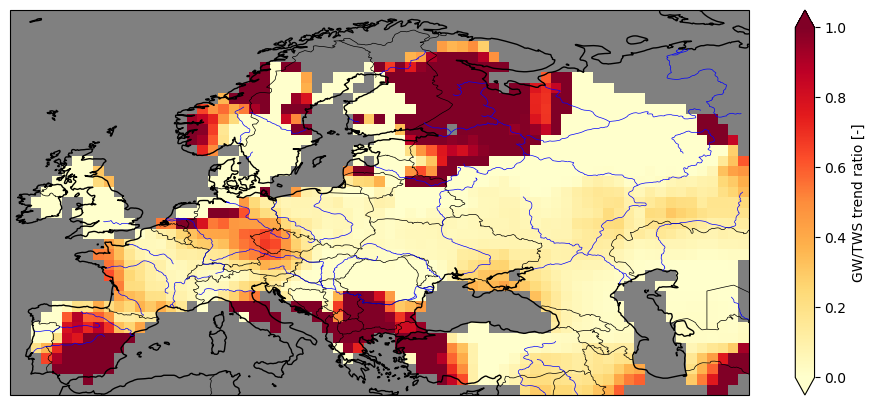

In [27]:
#PLot
#pvalue_mask_alpha.mask = ~pvalue_mask_alpha.mask
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('YlOrRd')
# Set the range for colors
vmin, vmax = 0 , 1
#alpha = 1
# Plot the slope without normalization
c = ax.pcolormesh(GW_TWS_trend_ratio['lon'].values, GW_TWS_trend_ratio['lat'].values, GW_TWS_trend_ratio['trend_ratio'].values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto', alpha=1)

cmap.set_bad(color='grey', alpha=1.0) 
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')
ax.add_feature(countries, linestyle='-', linewidth=0.5)
ax.add_feature(rivers, linestyle='-', linewidth=0.5)

# Add colorbar
plt.colorbar(c, ax=ax, label='GW/TWS trend ratio [-]',  extend='both', orientation='vertical')
# Show the plot
plt.show()

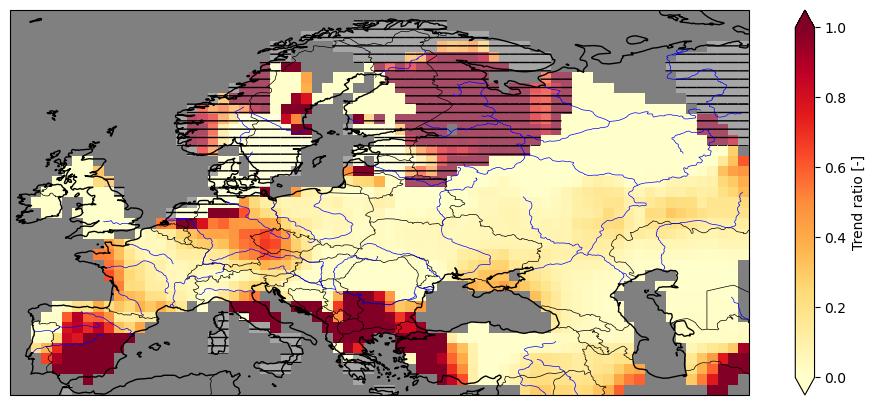

In [28]:
#PLot trend ratio and exclude GW trend > 0
TWS_trend_mask = np.ma.masked_greater(TWS_trend_Grace['slope'],0)
TWS_trend_mask_hatch = np.ma.masked_less(TWS_trend_Grace['slope'],0)
#pvalue_mask_alpha.mask = ~pvalue_mask_alpha.mask
alpha = np.where(TWS_trend_mask.mask, 0.7,1)

fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('YlOrRd')
# Set the range for colors
vmin, vmax = 0 , 1
#alpha = 1
# Plot the slope without normalization
c = ax.pcolormesh(GW_TWS_trend_ratio['lon'].values, GW_TWS_trend_ratio['lat'].values, GW_TWS_trend_ratio['trend_ratio'].values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto', alpha=alpha)
plt.pcolor(GW_TWS_trend_ratio['lon'].values, GW_TWS_trend_ratio['lat'].values, TWS_trend_mask_hatch, hatch='--', alpha=0)
cmap.set_bad(color='grey', alpha=1.0) 
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')
ax.add_feature(countries, linestyle='-', linewidth=0.5)
ax.add_feature(rivers, linestyle='-', linewidth=0.5)

# Add colorbar
plt.colorbar(c, ax=ax, label='Trend ratio [-]',  extend='both', orientation='vertical')
# Show the plot
plt.show()